In [1]:
import numpy as np
import pandas as pd
import random, math
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
# Make connection matrix
def make_connection_matrix(toa, tod, N, K, J):
    """
    Makes the connection matrix described in document

        Parameters:
            toa(array): List of time of arrival for vehicles
            tod(array): List of time of departure for vehicles
            N(int):    Number of vehicles
            K(int):    Number of time slots for 24 hours
            J(int):    Number of time slots for 1 hour
    
        Returns:
            C(array): Connection matrix
    """

    C = np.zeros((N,K))

    for cntn in range(N):
        for cntk in range(K):
            if(toa[cntn] <= cntk/J and tod[cntn] >= cntk/J):
                C[cntn, cntk] = 1
    
    return C

In [67]:
# ----- Defines and Example data -----
J= 4
K = 24*J; #Number of Time slots
N = 3; #Number of vehicle
Ts = 1/J; #sample time

battery_cap = 100*np.ones((N,1)); #battery capacity
SOCstart = np.asarray((0, 0, 0)); #state of charge
pmax_grid = 50*np.ones((K,1)); #maximum allowable power at every slots
pmax = 22*np.ones((N*K,1)) #maximum charge power for each station
pmin = 4*np.ones((N*K,1)) #minimum charge power for each station (0 when not charging)

q = np.zeros((N,1)) #battery level when fully charged at the end of charging
for i in range(N):
    q[i] = (1/Ts)*(1-SOCstart[i])*battery_cap[i]

q_min = np.zeros((N,1)) #minimum desired battery level at the end charging
for i in range(N):
    q_min[i] = (1/Ts)*(np.maximum(0.8,SOCstart[i])-SOCstart[i])*battery_cap[i]

In [68]:
# mu = 8; sigma = 1; random.seed(10)
# toa = [round(num, 2) for num in [random.gauss(mu, sigma) for i in range(N)]]
# print(toa)
# mu = 16; sigma = 1; random.seed(100)
# tod = [round(num, 2) for num in [random.gauss(mu, sigma) for i in range(N)]]
# print(tod)

toa = np.asarray([8.0, 8.0, 8.0]).reshape(-1)
tod = np.asarray([15.0, 16.0, 17.0])



In [69]:
print("toa",toa, "\ntod", tod, "\nN", N, "\nK", K, "\nJ", J)
C = make_connection_matrix(toa,tod,N,K,J)
print(C)

toa [8. 8. 8.] 
tod [15. 16. 17.] 
N 3 
K 96 
J 4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [70]:
df = pd.read_csv("example_load.csv", header=0, parse_dates=[0], index_col=0)
base_load = df.loc['2017-08-08']['average']
base_load = base_load * 100
max_load = max(base_load) + 10
pmax_ch = (max_load - base_load)/2
pmax_ch = np.array(pmax_ch).reshape(len(pmax_ch),1)
print(pmax_ch[1:10])

[[40.45]
 [43.05]
 [49.25]
 [54.35]
 [57.25]
 [61.35]
 [62.25]
 [57.25]
 [58.55]]


In [71]:
cfit = np.sum(C,axis=0)
#p_ta = 40*np.ones((K,1)); #target function
p_ta = pmax_ch
for k in range(K):
    if(cfit[k]==0.0):
        p_ta[k] = 0.0

In [72]:
c = C.flatten()

Aux = np.dot(np.kron(np.ones((1,N)), np.eye(K)), np.diagflat(c, k=0))

In [73]:
g = -2.0 * np.dot(np.transpose(p_ta), Aux)

H = 2 * np.dot(np.transpose(Aux), Aux)

In [21]:
print('---------- Quadratic Programming -------------')
# ---- Build matrix for constraint ----
# ---- min EV charging power ----
G1 = -1*np.eye(N*K)

h1 = -1*0*np.ones((N*K,1))
# ---- max EV charging power ----
G2 = np.eye(N*K)
h2 = np.dot(np.diagflat(c,k=0),pmax)
# ---- max charging power for all EVs ----
G3 = Aux
h3 = np.minimum(p_ta,pmax_grid)
# ---- battery level for all EVs ----
B=np.dot(np.kron(np.eye(N),np.ones((1,K))),np.diagflat(c,k=0))
G4 = B
h4 = q
G5 = -1*B
h5 = -1*q_min
G = np.vstack((np.vstack((np.vstack((np.vstack((G1,G2)),G3)),G4)),G5))
h = np.vstack((np.vstack((np.vstack((np.vstack((h1,h2)),h3)),h4)),h5)).flatten()

# ---- Solve quadratic programming with different solvers.
x = cp.Variable(N*K)
prob = cp.Problem(cp.Minimize((1/2)* cp.quad_form(x, H) + g @ x),
[G @ x <= h])
# By default CVXPY calls the solver most specialized to the problem type
prob.solve()
# solver type: cvxopt, gurobi
# optSolver = 'gurobi'
# if optSolver == 'cvxopt':
#     # Solve with CVXOPT.
#     prob.solve(solver=cp.CVXOPT)
#     print("optimal value with CVXOPT:", prob.value)
# if optSolver == 'gurobi':
#     # Solve with GUROBI.
#     prob.solve(solver=cp.GUROBI)
#     print("optimal value with GUROBI:", prob.value)
tmp = np.zeros((N,K))
for n in range(N):
    for k in range(K):
        tmp[n,k] = x.value[n*K+k]

---------- Quadratic Programming -------------


In [60]:
print('---------- Mixed Integer Quadratic Programming -------------')
# ---- Build matrix for constraint ----
# ---- min EV charging power ----
G11_1 = np.diagflat(np.dot(np.diagflat(c,k=0),pmin),k=0)
G12_1 = -1*np.eye(N*K)
# ---- max EV charging power ----
G11_2 = -1*np.diagflat(np.dot(np.diagflat(c,k=0),pmax),k=0)
G12_2 = np.eye(N*K)
G11 = np.vstack((G11_1,G11_2))
G12 = np.vstack((G12_1,G12_2))
h1 = np.vstack((np.zeros((N*K,1)), np.zeros((N*K,1))))
# ---- max charging power for all EVs ----
G22_1 = Aux
h2_1 = np.minimum(p_ta,pmax_grid) #both p_ta and pmax_grid are treated as constraints

# ---- battery level for all EVs ----
B = np.dot(np.kron(np.eye(N),np.ones((1,K))),np.diagflat(c,k=0))
G22_2 = B
h2_2 = q
G22_3 = -1*B
h2_3 = -1*q_min
G22 = np.vstack((G22_1,G22_2))
G22 = np.vstack((G22,G22_3))
h2 = np.vstack((h2_1,h2_2))
h2 = np.vstack((h2,h2_3))
G21 = np.zeros((G22.shape[0],G11.shape[1]))
G = np.vstack((np.hstack((G11,G12)),np.hstack((G21,G22))))
h = np.vstack((h1,h2)).flatten()
# ---- Solve mixed interger quadratic programming ----
x = cp.Variable(N*K, boolean=True) #slack binary variable x, y>=pmin*x, y<=pmax*x
y = cp.Variable(N*K)
prob = cp.Problem(cp.Minimize((1/2)* cp.quad_form(x, H) + g @ x),
[G @ cp.hstack((x, y)) <= h]) #,A @ x == b
# solver type: gurobi,
# optSolver = 'gurobi'
# if optSolver == 'gurobi':
# # Solve with GUROBI.
#     prob.solve(solver=cp.GUROBI)
prob.solve()
print("optimal value:", prob.value)
tmp = np.zeros((N,K))
for n in range(N):
    for k in range(K):
        tmp[n,k] = y.value[n*K+k]

---------- Mixed Integer Quadratic Programming -------------
optimal value: -10150.8


In [76]:
prob_metrics = cp.problems.problem.SizeMetrics(prob)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [75]:
print("N:", N)
print("Ts:", Ts)
print("J:", J)
print("K:", K)
print("bat_cap:", battery_cap.shape)
print("soc", SOCstart.shape)
print("pmax:", pmax_grid.shape)
print("vmax:", pmax.shape)
print("vmin:", pmin.shape)
print("toa:", toa.shape)
print("tod:", tod.shape)
print("q:", q.shape)
print("q_min:", q_min.shape)
print("C:", C.shape)
print("target:", pmax_ch.shape)
print("cfit:", cfit.shape)
print("c:", c.shape)
print("A:", Aux.shape)
print("grad:", g.shape)
print("H:", H.shape)
print(battery_cap)

N: 3
Ts: 0.25
J: 4
K: 96
bat_cap: (3, 1)
soc (3,)
pmax: (96, 1)
vmax: (288, 1)
vmin: (288, 1)
toa: (3,)
tod: (3,)
q: (3, 1)
q_min: (3, 1)
C: (3, 96)
target: (96, 1)
cfit: (96,)
c: (288,)
A: (96, 288)
grad: (1, 288)
H: (288, 288)
[[100.]
 [100.]
 [100.]]


Charged Energy for Each EV:
[40.     36.     37.0625 32.     32.     33.     34.     32.    ]


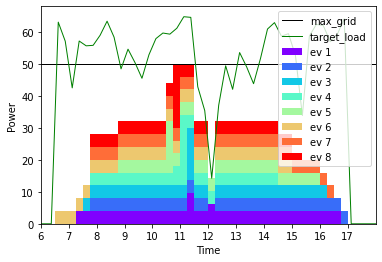

In [11]:
# ---- plot stacked powers ----
#tmp = tmp.clip(min=0)
print('Charged Energy for Each EV:')
print(tmp.sum(axis=1)/J)
#print('-------- Charge Power for Each EV for Every Period ---------')
#print(tmp)
plt.close('all')
plt.figure()
x_axis = np.arange(1,K+1,1)/J - 1/J/2
plt.plot(x_axis, pmax_grid, color='black', linewidth=1)
plt.plot(x_axis, p_ta, color='green', linewidth=1)
pltcolors = cm.rainbow(np.linspace(0,1,N))
barWidth = 1/J
plt.bar(x_axis, tmp[0,:], color=pltcolors[0], width=barWidth)
bars_ud_all = np.zeros((K,1))
for i in range(1,N):
    bars_ud = tmp[i-1,:]
    if i>1:
        bars_ud = np.add(bars_ud, bars_ud_all)
    bars_ud_all = bars_ud
    plt.bar(x_axis, tmp[i,:], bottom=bars_ud_all.tolist(), color=pltcolors[i], width=barWidth)

x_low = math.floor(np.min(toa))
x_up = math.ceil(np.max(tod))+1
plt.xlim([x_low, x_up])
plt.xticks(np.arange(x_low, x_up, 1))

labeltxt = np.hstack(['max_grid', 'target_load'])
for i in range(N):
    evtxt = 'ev '+str(i+1)
    labeltxt = np.hstack([labeltxt, evtxt])
plt.legend(labels=labeltxt)
plt.xlabel("Time")
plt.ylabel("Power")
plt.show()